In [33]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))



/kaggle/input/facial-expression-recognitionferchallenge/Submission.csv
/kaggle/input/facial-expression-recognitionferchallenge/fer2013/fer2013/README
/kaggle/input/facial-expression-recognitionferchallenge/fer2013/fer2013/fer2013.bib
/kaggle/input/facial-expression-recognitionferchallenge/fer2013/fer2013/fer2013.csv


In [34]:
import math
import numpy as np
import pandas as pd

import scikitplot
import seaborn as sns
from matplotlib import pyplot

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dropout, BatchNormalization, LeakyReLU, Activation
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from keras.utils import np_utils

In [35]:
df = pd.read_csv('../input/facial-expression-recognition-dataset.csv')
print(df.shape)
df.head()

(35887, 3)


,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [36]:
df.emotion.unique()

array([0, 2, 4, 6, 3, 5, 1])

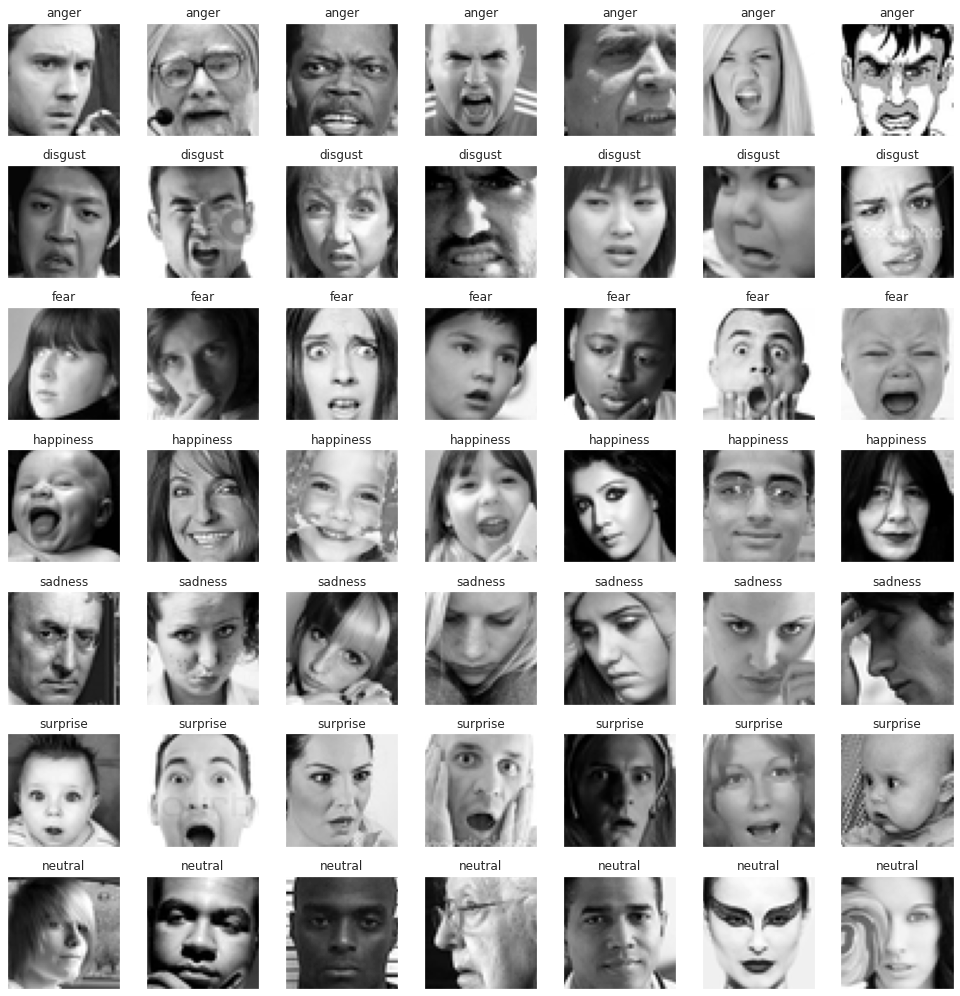

In [41]:
fig = pyplot.figure(1, (14, 14))

k = 0
for label in sorted(df.emotion.unique()):
    for j in range(7):
        px = df[df.emotion==label].pixels.iloc[k]
        px = np.array(px.split(' ')).reshape(48, 48).astype('float32')

        k += 1
        ax = pyplot.subplot(7, 7, k)
        ax.imshow(px, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(emotion_label_to_text[label])
        pyplot.tight_layout()

In [42]:
INTERESTED_LABELS = [3, 4, 6]

In [43]:
df = df[df.emotion.isin(INTERESTED_LABELS)]
df.shape

(21264, 3)

#### Make the data compatible for neural networks

In [44]:
img_array = df.pixels.apply(lambda x: np.array(x.split(' ')).reshape(48, 48, 1).astype('float32'))
img_array = np.stack(img_array, axis=0)

In [45]:
img_array.shape

(21264, 48, 48, 1)

In [46]:
le = LabelEncoder()
img_labels = le.fit_transform(df.emotion)
img_labels = np_utils.to_categorical(img_labels)
img_labels.shape

(21264, 3)

In [47]:
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(le_name_mapping)

{3: 0, 4: 1, 6: 2}


`Splitting the data into training and validation set.`

In [48]:
X_train, X_valid, y_train, y_valid = train_test_split(img_array, img_labels,shuffle=True, stratify=img_labels,test_size=0.1, random_state=42)
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((19137, 48, 48, 1), (2127, 48, 48, 1), (19137, 3), (2127, 3))

In [49]:
del df
del img_array
del img_labels

In [50]:
img_width = X_train.shape[1]
img_height = X_train.shape[2]
img_depth = X_train.shape[3]
num_classes = y_train.shape[1]

In [51]:
# Normalizing results, as neural networks are very sensitive to unnormalized data.
X_train = X_train / 255.
X_valid = X_valid / 255.

In [52]:
def build_model(optim):
    # Initialize a Sequential model with the name 'DCNN'
    model = Sequential(name='DCNN')

    # Block 1: Convolutional Layer, Batch Normalization, Convolutional Layer, Batch Normalization
    model.add(Conv2D(filters=64, kernel_size=(5, 5), input_shape=(img_width, img_height, img_depth),
                     activation='elu', padding='same', kernel_initializer='he_normal', name='conv2d_1'))
    model.add(BatchNormalization(name='batchnorm_1'))
    model.add(Conv2D(filters=64, kernel_size=(5, 5), activation='elu', padding='same', kernel_initializer='he_normal',
                     name='conv2d_2'))
    model.add(BatchNormalization(name='batchnorm_2'))

    # Max Pooling Layer, Dropout Layer
    model.add(MaxPooling2D(pool_size=(2, 2), name='maxpool2d_1'))
    model.add(Dropout(0.4, name='dropout_1'))

    # Block 2: Convolutional Layer, Batch Normalization, Convolutional Layer, Batch Normalization
    model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='elu', padding='same', kernel_initializer='he_normal',
                     name='conv2d_3'))
    model.add(BatchNormalization(name='batchnorm_3'))
    model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='elu', padding='same', kernel_initializer='he_normal',
                     name='conv2d_4'))
    model.add(BatchNormalization(name='batchnorm_4'))

    # Max Pooling Layer, Dropout Layer
    model.add(MaxPooling2D(pool_size=(2, 2), name='maxpool2d_2'))
    model.add(Dropout(0.4, name='dropout_2'))

    # Block 3: Convolutional Layer, Batch Normalization, Convolutional Layer, Batch Normalization
    model.add(Conv2D(filters=256, kernel_size=(3, 3), activation='elu', padding='same', kernel_initializer='he_normal',
                     name='conv2d_5'))
    model.add(BatchNormalization(name='batchnorm_5'))
    model.add(Conv2D(filters=256, kernel_size=(3, 3), activation='elu', padding='same', kernel_initializer='he_normal',
                     name='conv2d_6'))
    model.add(BatchNormalization(name='batchnorm_6'))

    # Max Pooling Layer, Dropout Layer
    model.add(MaxPooling2D(pool_size=(2, 2), name='maxpool2d_3'))
    model.add(Dropout(0.5, name='dropout_3'))

    # Flatten Layer
    model.add(Flatten(name='flatten'))

    # Fully Connected Layer, Batch Normalization
    model.add(Dense(128, activation='elu', kernel_initializer='he_normal', name='dense_1'))
    model.add(BatchNormalization(name='batchnorm_7'))

    # Dropout Layer, Output Layer
    model.add(Dropout(0.6, name='dropout_4'))
    model.add(Dense(num_classes, activation='softmax', name='out_layer'))

    # Compile the model with categorical crossentropy loss, optimizer, and evaluation metrics
    model.compile(loss='categorical_crossentropy', optimizer=optim, metrics=['accuracy'])

    # Display a summary of the model architecture
    model.summary()

    # Return the built model
    return model


In [53]:

early_stopping = EarlyStopping(monitor='val_accuracy',min_delta=0.00005,patience=11,verbose=1,restore_best_weights=True,)
lr_scheduler = ReduceLROnPlateau(monitor='val_accuracy',factor=0.5,patience=7,min_lr=1e-7,verbose=1,)
callbacks = [early_stopping,lr_scheduler,]

In [54]:
# As the data in hand is less as compared to the task so ImageDataGenerator is good to go.
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
)
train_datagen.fit(X_train)

In [55]:
batch_size = 32 #batch size of 32 performs the best.
epochs = 100
optims = [
    optimizers.Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, name='Nadam'),
    optimizers.Adam(0.001),
]

# I tried both `Nadam` and `Adam`, the difference in results is not different but I finally went with Nadam as it is more popular.
model = build_model(optims[1]) 
history = model.fit_generator(
    train_datagen.flow(X_train, y_train, batch_size=batch_size),
    validation_data=(X_valid, y_valid),
    steps_per_epoch=len(X_train) / batch_size,
    epochs=epochs,
    callbacks=callbacks,
    use_multiprocessing=True
)

Model: "DCNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 48, 48, 64)        1664      
_________________________________________________________________
batchnorm_1 (BatchNormalizat (None, 48, 48, 64)        256       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 48, 48, 64)        102464    
_________________________________________________________________
batchnorm_2 (BatchNormalizat (None, 48, 48, 64)        256       
_________________________________________________________________
maxpool2d_1 (MaxPooling2D)   (None, 24, 24, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 24, 128)       73856  

In [56]:
model_yaml = model.to_yaml()
with open("model.yaml", "w") as yaml_file:
    yaml_file.write(model_yaml)
    
model.save("model.h5")

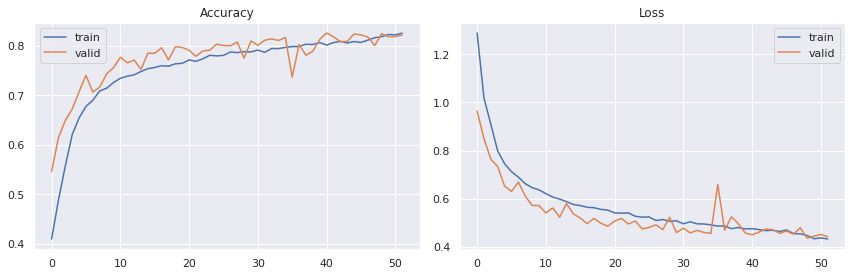

In [57]:
sns.set()
fig = pyplot.figure(0, (12, 4))

ax = pyplot.subplot(1, 2, 1)
sns.lineplot(history.epoch, history.history['accuracy'], label='train')
sns.lineplot(history.epoch, history.history['val_accuracy'], label='valid')
pyplot.title('Accuracy')
pyplot.tight_layout()

ax = pyplot.subplot(1, 2, 2)
sns.lineplot(history.epoch, history.history['loss'], label='train')
sns.lineplot(history.epoch, history.history['val_loss'], label='valid')
pyplot.title('Loss')
pyplot.tight_layout()

pyplot.savefig('epoch_history_dcnn.png')
pyplot.show()